In [1]:
from lib.utilities import *
from lib.file_writer import FileWriter
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
fw = FileWriter()
print(fw.save_data_file)

#def save_data_file(self, images, num_trials, num_pts, int_pts, num_fp_pts, width, height,
# rliLow, rliHigh, rliMax, sliceNo, locNo, recNo, program, int_trials)

<bound method FileWriter.save_data_file of <lib.file_writer.FileWriter object at 0x000001F719CDEA00>>


In [3]:
datadir = "./tsm_targets/01-17-22" # All files in this directory + subdirectories are loaded
datadir = "./tsm_targets" # All files in this directory + subdirectories are loaded
datadir = "C:/Turbo-SM/SMDATA/Untitled"
#datadir = "C:/Turbo-SM/SMDATA/John/01-17-22"
selected_filename = "Untitled006" # focus for subsequent analysis
selected_filename = "OMP25-Cerulean3-cell4003"
file_type = '.tsm'
horizontal_cropping = [250, 750]  # This is the cropping recommended for 1024-px width
horizontal_cropping = [125, 375]  # This is the cropping recommended for 512-px width
t_cropping = [0, -1]  # TSM artifacts
binning = 3

In [4]:
# Load data
processed = [] # to avoid re-processing later
data_loader = DataLoader()
if file_type == '.tsm':
    data_loader.load_all_tsm(data_dir=datadir, file_only=selected_filename)
    
print(data_loader.get_n_files_loaded(), "files loaded.")

cb5-Cerulean3-cell1.tbn
cb5-Cerulean3-cell1001.tbn
Cerulean3-P450-cell1.tbn
Cerulean3-P450-cell1001.tbn
Cerulean3-P450-cell2.tbn
Cerulean3-P450-cell2001.tbn
Cerulean3-Tom20-cell1.tbn
Cerulean3-Tom20-cell1a.tbn
MAVIS-Cerulean3-cell002.tbn
MAVIS-Cerulean3-cell1.tbn
MAVIS-Cerulean3-cell1001.tbn
MAVIS-Cerulean3-cell1002.tbn
MAVIS-Cerulean3-cell1BB.tbn
OMP25-Cerulean3-cell1.tbn
OMP25-Cerulean3-cell1.tsm
OMP25-Cerulean3-cell1001.tbn
OMP25-Cerulean3-cell1001.tsm
OMP25-Cerulean3-cell1002.tbn
OMP25-Cerulean3-cell1002.tsm
OMP25-Cerulean3-cell1003.tbn
OMP25-Cerulean3-cell1003.tsm
OMP25-Cerulean3-cell2-avrage.tbn
OMP25-Cerulean3-cell2-avrage.tsm
OMP25-Cerulean3-cell2.tbn
OMP25-Cerulean3-cell2.tsm
OMP25-Cerulean3-cell2001.tbn
OMP25-Cerulean3-cell2001.tsm
OMP25-Cerulean3-cell2002.tbn
OMP25-Cerulean3-cell2002.tsm
OMP25-Cerulean3-cell2003.tbn
OMP25-Cerulean3-cell2003.tsm
OMP25-Cerulean3-cell3.tbn
OMP25-Cerulean3-cell3.tsm
OMP25-Cerulean3-cell3001.tbn
OMP25-Cerulean3-cell3001.tsm
OMP25-Cerulean3-cell30

In [5]:
# Select data of interest        
selected_data = data_loader.select_data_by_keyword(selected_filename)

# If PhotoZ cannot manage the image size, increase binning and cropping
selected_data.clip_data(y_range=horizontal_cropping, t_range=t_cropping)
selected_data.bin_data(binning=binning)

raw_data, meta, rli = selected_data.get_data(), selected_data.get_meta(), selected_data.get_rli()
fp_data = selected_data.fp_data

{'points_per_trace': 59, 'raw_width': 59, 'raw_height': 10, 'interval_between_samples': 1.0, 'number_of_trials': 1} (1, 59, 159, 250)


(1, 59, 53, 84)


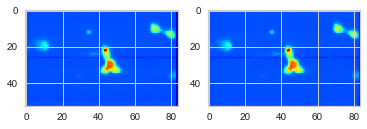

In [5]:
# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()

rli_high_cp = np.copy(raw_data[0,0,:,:]).astype(np.uint16)

In [6]:
# Fill in missing metadata
meta['version'] = 5
meta['slice_number'] = 5
meta['location_number'] = 5
meta['record_number'] = 5
meta['camera_program'] = 2

meta['interval_between_trials'] = 1
meta['acquisition_gain'] = 1
meta['time_RecControl'] = 5

meta['reset_onset'] = 1
meta['reset_duration'] = 5
meta['shutter_onset'] = 5
meta['shutter_duration'] = 5

meta['stimulation1_onset'] = 20
meta['stimulation1_duration'] = 1
meta['stimulation2_onset'] = 0
meta['stimulation2_duration'] = 0

meta['acquisition_onset'] = 1
meta['interval_between_samples'] = 5

meta['raw_width'] = raw_data.shape[2]
meta['raw_height'] = raw_data.shape[3]
meta['points_per_trace'] = raw_data.shape[1]
meta['number_of_trials'] = raw_data.shape[0]
num_fp_pts = 4
num_diodes = int(meta['raw_width'] * meta['raw_height'] + num_fp_pts)
rli = {}
rli['rli_low'] = [0] * num_diodes
rli['rli_high'] = np.zeros((num_diodes)) 
rli['rli_high'][:meta['raw_width'] * meta['raw_height']] = np.swapaxes(rli_high_cp, 1, 0).reshape(-1)
rli['rli_max'] = [1] * num_diodes

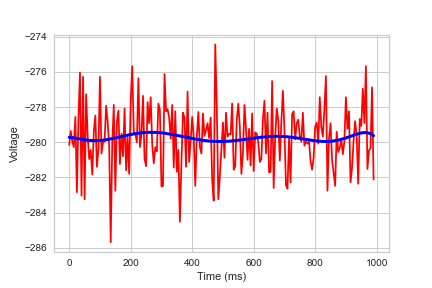

In [7]:
# Run this cell at most once

# Apply baseline correction here. Because PhotoZ chokes on baseline correcting TurboSM data
tr = Tracer()
#data inversing
raw_data = -raw_data

# Need to subtract off the low-frequency voltage drift. First-order correction
tr.correct_background(meta, raw_data)

(1, 59, 53, 84) [[[[1883 2247 2254 ... 1850 2032 1944]
   [1856 2113 2270 ... 2078 2158 2117]
   [2121 1990 2205 ... 2087 1998 1991]
   ...
   [1932 2269 2123 ... 2112 1964 2118]
   [2222 2136 2084 ... 2195 2285 1956]
   [1919 1672 2027 ... 2028 2317 2080]]

  [[2000 1576 1875 ... 2363 1820 2068]
   [2220 1683 1515 ... 1909 1870 1927]
   [1770 2027 1643 ... 2079 1916 2157]
   ...
   [2147 1828 2055 ... 2011 2005 1935]
   [1656 1842 1915 ... 1820 1475 2081]
   [2151 2603 2125 ... 2059 1437 1956]]

  [[2641 2624 1809 ... 2040 2533 2164]
   [2239 2502 2502 ... 1979 2000 1932]
   [1999 2208 2044 ... 1793 2256 1805]
   ...
   [2303 1934 1766 ... 1650 2212 1834]
   [2172 2110 2096 ... 1933 2347 2156]
   [2311 2218 2043 ... 1909 2340 2085]]

  ...

  [[1466 1314 1495 ... 1658 1935 1854]
   [2012 1381 1944 ... 1992 1811 1964]
   [2067 2337 1510 ... 2210 1907 2025]
   ...
   [1913 2219 2751 ... 2080 1952 2023]
   [2055 1982 2393 ... 2253 2423 2168]
   [1711 1946 1761 ... 2050 2161 1784]]

  [[2

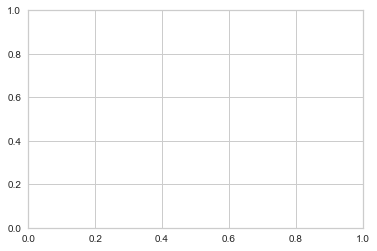

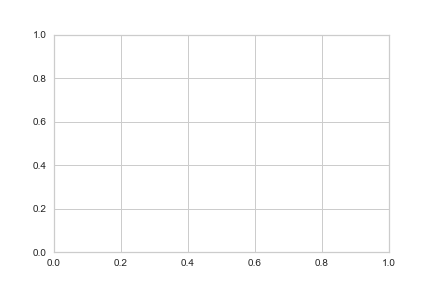

In [8]:
plt.subplots() # finalize plot from previous cell
# normalize raw data to 12-bit range
def normalize_bit_range(raw_data, bits=12):
    raw_data = raw_data.astype(np.float64)
    raw_data -= np.min(raw_data)
    raw_data /= np.max(raw_data)
    raw_data *= (2 ** bits)

    return raw_data.astype(np.uint16)

fp_data = normalize_bit_range(fp_data)
raw_data = normalize_bit_range(raw_data)
print(raw_data.shape, raw_data)

# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()


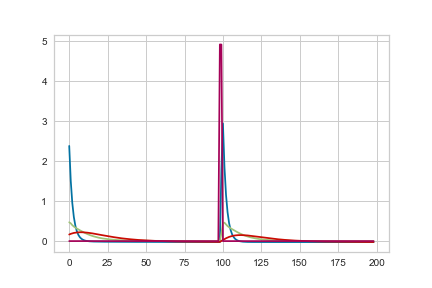

In [9]:
fig, ax = plt.subplots()
ax.plot(fp_data[t_cropping[0]:t_cropping[1], :])

[[[[1883 2247 2254 ... 1850 2032 1944]
   [1856 2113 2270 ... 2078 2158 2117]
   [2121 1990 2205 ... 2087 1998 1991]
   ...
   [1932 2269 2123 ... 2112 1964 2118]
   [2222 2136 2084 ... 2195 2285 1956]
   [1919 1672 2027 ... 2028 2317 2080]]

  [[2000 1576 1875 ... 2363 1820 2068]
   [2220 1683 1515 ... 1909 1870 1927]
   [1770 2027 1643 ... 2079 1916 2157]
   ...
   [2147 1828 2055 ... 2011 2005 1935]
   [1656 1842 1915 ... 1820 1475 2081]
   [2151 2603 2125 ... 2059 1437 1956]]

  [[2641 2624 1809 ... 2040 2533 2164]
   [2239 2502 2502 ... 1979 2000 1932]
   [1999 2208 2044 ... 1793 2256 1805]
   ...
   [2303 1934 1766 ... 1650 2212 1834]
   [2172 2110 2096 ... 1933 2347 2156]
   [2311 2218 2043 ... 1909 2340 2085]]

  ...

  [[1466 1314 1495 ... 1658 1935 1854]
   [2012 1381 1944 ... 1992 1811 1964]
   [2067 2337 1510 ... 2210 1907 2025]
   ...
   [1913 2219 2751 ... 2080 1952 2023]
   [2055 1982 2393 ... 2253 2423 2168]
   [1711 1946 1761 ... 2050 2161 1784]]

  [[2009 2373 2278 ..

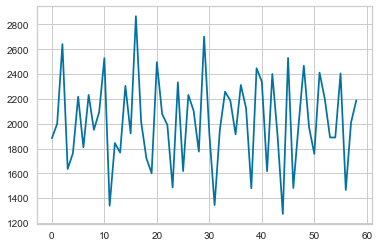

In [10]:
# Write data
print(raw_data, raw_data.shape)
zda_writer = ZDA_Writer()
zda_writer.write_zda_to_file(raw_data, meta, selected_filename + ".zda", rli, fp_data[t_cropping[0]:t_cropping[1], :])

plt.plot(raw_data[0,:,0,0])